# Assignment 5: GANs - Kai Ponel & Hannan Mahadik 

# Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
# import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, losses, optimizers, metrics
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten,Activation
import os

import matplotlib.pyplot as plt

2023-05-18 17:47:01.347988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 17:47:04.318610: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/scratch/ponel/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-05-18 17:47:04.318909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image
import pandas as pd

In [3]:
path_to_data = '/content/drive/MyDrive/ColabNotebooks/LGM_Hannan_Kai/Task 5/animals'

# Dataset

# MNIST


In [4]:
with np.load('/data/project/FoolingDetection/mnist.npz') as data:
    x_train, y_train = data['x_train'], data['y_train']
    x_test, y_test = data['x_test'], data['y_test']

x_train = x_train/255
x_test = x_test/255

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

batch_size = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

In [5]:
# ds = tf.keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = ds.load_data()

In [6]:
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(BATCH_SIZE)

# Model

In [9]:
LATENT_DIM = 10

## Generator

In [10]:
class Generator(layers.Layer):

  def __init__(self, LATENT_DIM):
    self.LATENT_DIM = LATENT_DIM

    super(Generator, self).__init__()

  def build(self, input_shape):
    BATCH_DIM = input_shape[0]

    self.dense1 = Dense(7*7*256, input_shape=(BATCH_DIM, self.LATENT_DIM))
    self.bn1 = BatchNormalization()
    self.lr1 = LeakyReLU()

    self.reshape = Reshape((7, 7, 256), input_shape = (BATCH_DIM, 7*7*256))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    self.convt1 = Conv2DTranspose(128, 5, strides=1, padding='same', input_shape = (BATCH_DIM, 7, 7, 256))
    # assert model.output_shape == (None, 7, 7, 128)
    self.bn2 = BatchNormalization()
    self.lr2 = LeakyReLU()

    self.convt2 = Conv2DTranspose(64, 5, strides=2, padding='same', input_shape = (BATCH_DIM, 14, 14, 128))
    # assert model.output_shape == (None, 14, 14, 64)
    self.bn3 = BatchNormalization()
    self.lr3 = LeakyReLU()

    self.convt3 = Conv2DTranspose(1, 5, strides=2, padding='same', input_shape = (BATCH_DIM, 28, 28, 64))
    # assert model.output_shape == (None, 28, 28, 1)


  @tf.function
  def call(self, noise):
    x = self.dense1(noise)
    x = self.bn1(x)
    x = self.lr1(x)
    x = self.reshape(x) 

    x = self.convt1(x)
    x = self.bn2(x)
    x = self.lr2(x)

    x = self.convt2(x)
    x = self.bn3(x)
    x = self.lr3(x)

    x = self.convt3(x)

    return x

In [11]:
generator = Generator(LATENT_DIM)

noise = tf.random.normal([1, 100])

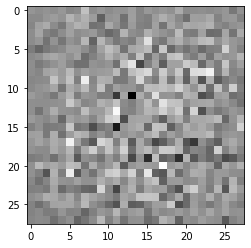

In [12]:
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

In [13]:
class Discriminator(layers.Layer):

  def __init__(self):
    super(Discriminator, self).__init__()

  def build(self, input_shape):
    self.conv1 = Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1))
    self.lr1 = LeakyReLU()
    self.do1 = Dropout(0.3)

    self.conv2 = Conv2D(256, 5, strides=2, padding='same')
    self.lr2 = LeakyReLU()
    self.do2 = Dropout(0.3)

    self.flatten = Flatten()
    self.dense = Dense(1)

  @tf.function
  def call(self, input):
    x = self.conv1(input)
    x = self.lr1(x)
    x = self.do1(x) 

    x = self.conv2(x)
    x = self.lr2(x)
    x = self.do2(x)

    x = self.flatten(x)
    x = self.dense(x)

    return x


In [14]:
discriminator = Discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00082431]], shape=(1, 1), dtype=float32)


## GAN

In [15]:
# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

In [16]:
# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

In [50]:
class DC_GAN(tf.keras.Model):

  def __init__(self, LATENT_DIM, distribution, **kwargs):
    super(DC_GAN, self).__init__(**kwargs)

    self.LATENT_DIM = LATENT_DIM
    self.distribution = distribution
    self.generator = Generator(LATENT_DIM)
    self.discriminator = Discriminator()


  def compile(self):
    super(DC_GAN, self).compile()
    
    self.generator_optimizer = optimizers.Adam(1e-4)
    self.discriminator_optimizer = optimizers.Adam(1e-4)
    
    self.generator_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) 
    self.discriminator_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

    self.generator_loss_metric = tf.keras.metrics.Mean()
    self.discriminator_loss_metric = tf.keras.metrics.Mean()

  @property
  def metrics(self):
    return[self.generator_loss_metric, self.discriminator_loss_metric]

  @tf.function
  def train_step(self, input):
    batch_size = tf.shape(input)[0]

    # Train Discriminator    
    start = tf.random.normal([batch_size, self.LATENT_DIM])
    generated_batch = self.generator(start)

    real_labels = tf.ones((batch_size, 1))
    generated_labels = tf.zeros((batch_size, 1))

    full_batch = tf.concat([input, generated_batch], axis=0)
    full_labels = tf.concat([real_labels, generated_labels], axis=0)

    with tf.GradientTape() as disc_tape:
        preds = self.discriminator(full_batch, training=True)
        disc_loss = self.discriminator_loss(full_labels, preds)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    # Train Generator
    with tf.GradientTape() as gen_tape:
        start = tf.random.normal([batch_size, self.LATENT_DIM])
        generated_batch = self.generator(start, training=True)
        d_output = self.discriminator(generated_batch)
        gen_loss = self.generator_loss(real_labels, d_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    self.generator_loss_metric.update_state(gen_loss)
    self.discriminator_loss_metric.update_state(disc_loss)

    return {
        "Discriminator Loss": self.discriminator_loss_metric.result(),
        "Generator Loss": self.generator_loss_metric.result(),
    }




In [51]:
distribution = tfp.distributions.Normal(0,1)

In [52]:
DCGAN = DC_GAN(LATENT_DIM, distribution)
DCGAN.compile()

In [53]:
path = '/content/drive/MyDrive/ColabNotebooks/LGM_Hannan_Kai/Task 5'

In [54]:
checkpoint_dir = path + '/training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)

In [57]:
import os
epoch = -1
save_dir = '/home/ponel/lgm5'

class ImShowCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        global epoch
        if batch == 100:
            epoch = epoch + 1
            if epoch % 100 == 0:
                noise = self.model.distribution.sample((5, self.model.LATENT_DIM))
                gens = self.model.generator(noise)

                plt.figure(figsize=(15, 3))
                for i, img in enumerate(gens):
                    plt.subplot(1, 5, i + 1)
                    plt.imshow(img)
                    plt.axis("off")
                plt.suptitle("training step " + str(epoch))
                plt.show()

                # Save plot to local disk
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                filename = f'epoch_{epoch}.png'
                filepath = os.path.join(save_dir, filename)
                plt.savefig(filepath)

Epoch 1/25000
 99/235 [===========>..................] - ETA: 4s - Discriminator Loss: 0.3064 - Generator Loss: 1.6906

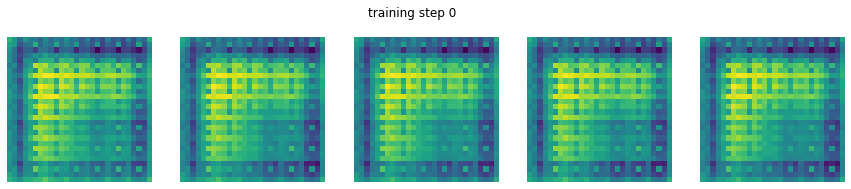

235/235 [==============================] - 8s 34ms/step - Discriminator Loss: 0.3080 - Generator Loss: 2.0110
Epoch 2/25000
235/235 [==============================] - 8s 32ms/step - Discriminator Loss: 0.3708 - Generator Loss: 1.4629
Epoch 3/25000
235/235 [==============================] - 8s 33ms/step - Discriminator Loss: 0.6220 - Generator Loss: 0.8204
Epoch 4/25000
235/235 [==============================] - 8s 33ms/step - Discriminator Loss: 0.5132 - Generator Loss: 1.6323
Epoch 5/25000
235/235 [==============================] - 8s 32ms/step - Discriminator Loss: 0.5242 - Generator Loss: 1.4576
Epoch 6/25000
 33/235 [===>..........................] - ETA: 6s - Discriminator Loss: 0.7222 - Generator Loss: 1.3951

In [ ]:
DCGAN.fit(train_dataset, epochs=25000, callbacks = [ImShowCallback()])